<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap20/20_1_Random_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 20.1: Random Data**

This notebook investigates training the network with random data, as illustrated in figure 20.1.

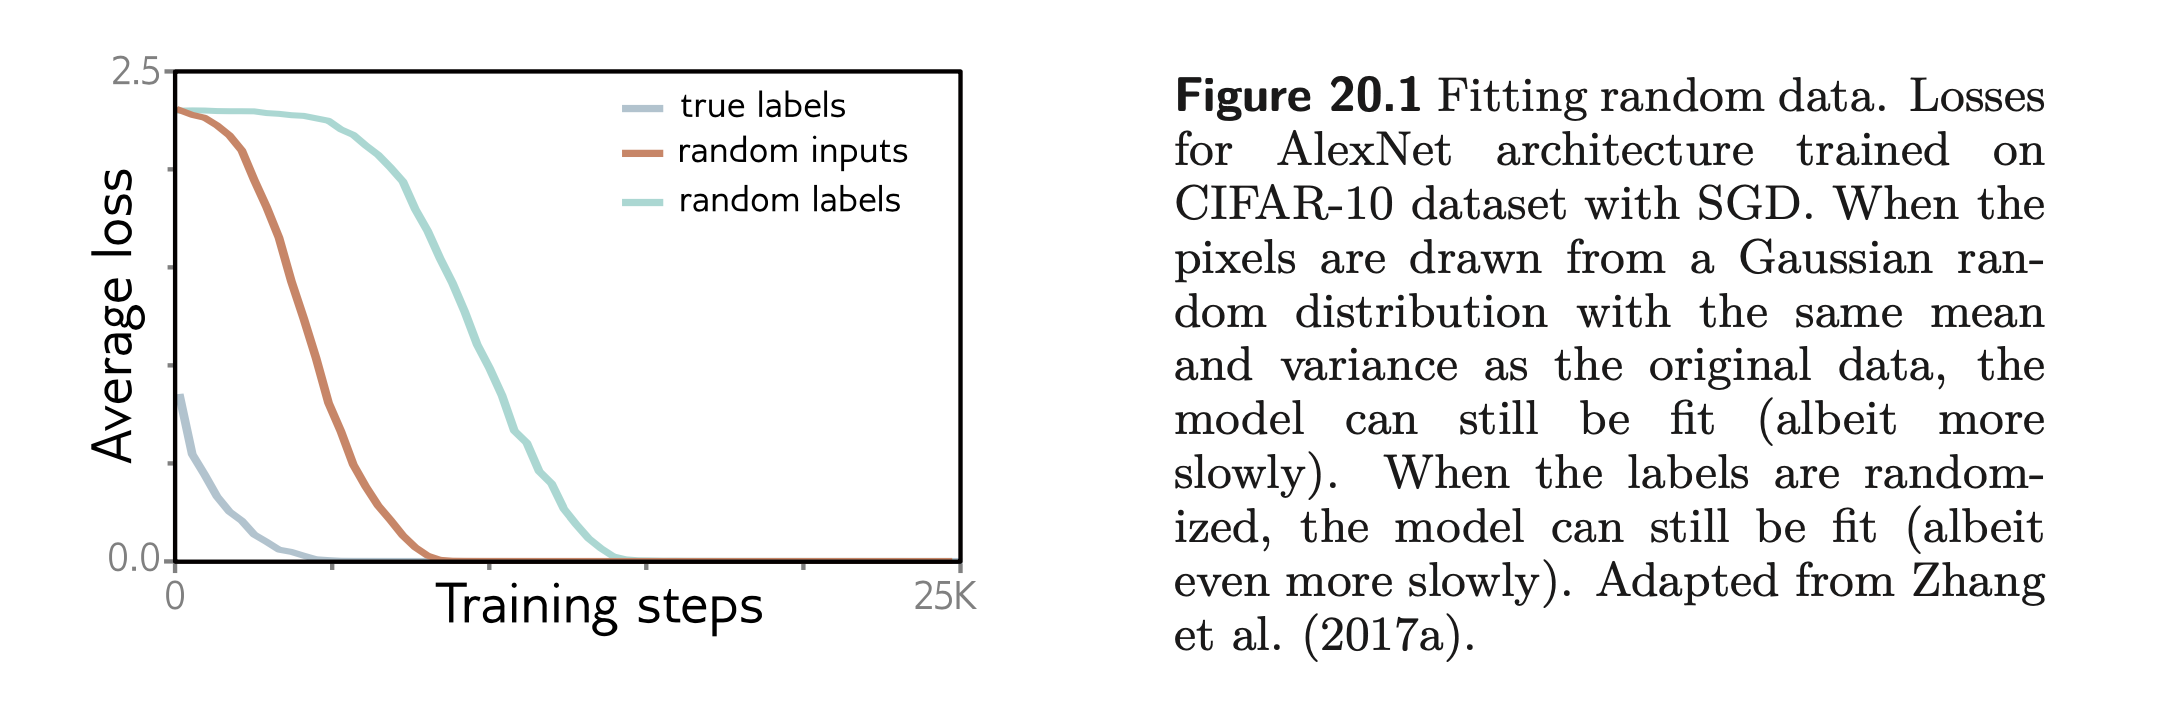

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [1]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
!git clone https://github.com/greydanus/mnist1d

fatal: destination path 'mnist1d' already exists and is not an empty directory.


In [2]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random
from IPython.display import display, clear_output

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 4000
Length of each example: 40


Define the network

In [4]:
D_i = 40    # Input dimensions
D_k = 300   # Hidden dimensions
D_o = 10    # Output dimensions

model = nn.Sequential(
nn.Linear(D_i, D_k),
nn.ReLU(),
nn.Linear(D_k, D_k),
nn.ReLU(),
nn.Linear(D_k, D_k),
nn.ReLU(),
nn.Linear(D_k, D_k),
nn.ReLU(),
nn.Linear(D_k, D_o))

In [5]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [6]:
def train_model(train_data_x, train_data_y, n_epoch):
  # choose cross entropy loss function (equation 5.24 in the loss notes)
  loss_function = nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate and momentum
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.02, momentum=0.9)
  # object that decreases learning rate by half every 20 epochs
  scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
  # create 100 dummy data points and store in data loader class
  x_train = torch.tensor(train_data_x.transpose().astype('float32'))
  y_train = torch.tensor(train_data_y.astype('long'))

  # load the data into a class that creates the batches
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

  # Initialize model weights
  model.apply(weights_init)

  # store the loss and the % correct at each epoch
  losses_train = np.zeros((n_epoch))

  for epoch in range(n_epoch):
    # loop over batches
    for i, data in enumerate(data_loader):
      # retrieve inputs and labels for this batch
      x_batch, y_batch = data
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass -- calculate model output
      pred = model(x_batch)
      # compute the loss
      loss = loss_function(pred, y_batch)
      # backward pass
      loss.backward()
      # SGD update
      optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    pred_train = model(x_train)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    losses_train[epoch] = loss_function(pred_train, y_train).item()
    if epoch % 5 == 0:
        clear_output(wait=True)
        display("Epoch %d, train loss %3.3f"%(epoch, losses_train[epoch]))

    # tell scheduler to consider updating learning rate
    scheduler.step()

  return losses_train

In [7]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)


'Epoch 55, train loss 0.002'

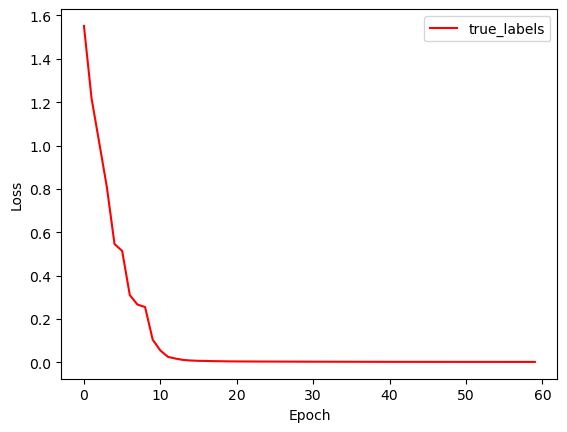

In [8]:
# Compute loss for proper data  and plot
n_epoch = 60
loss_true_labels = train_model(train_data_x, train_data_y, n_epoch)
# Plot the results
fig, ax = plt.subplots()
ax.plot(loss_true_labels,'r-',label='true_labels')
# ax.set_ylim(0,0.7); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [17]:
# TODO -- Randomize the input data (train_data_x), but retain overall mean and variance
# Replace this line
# Assuming train_data_x is your input data
train_data_x_randomized = np.copy(train_data_x)

# Shuffle the data along the first axis (rows)
np.random.shuffle(train_data_x_randomized)

In [18]:
print(train_data_x_randomized)

[[ 1.03961085  1.74578876 -1.29393302 ... -0.50664384  0.10104679
  -0.31363037]
 [-0.20761472 -0.27017787  0.36789098 ...  0.43285141  0.37766133
   0.53402211]
 [-0.84863879 -2.89647128 -0.03145525 ...  0.81811001 -0.06131031
   0.5835482 ]
 ...
 [-0.64214458 -3.05041337  0.15546124 ... -0.12068934 -2.59491945
  -0.09241186]
 [-0.24208785  0.04990925  0.30943896 ...  0.49234877  0.30989196
   0.48526979]
 [-0.51731037 -0.11234933  0.93235275 ... -0.2121629   0.13298385
   1.65389555]]


'Epoch 55, train loss 0.002'

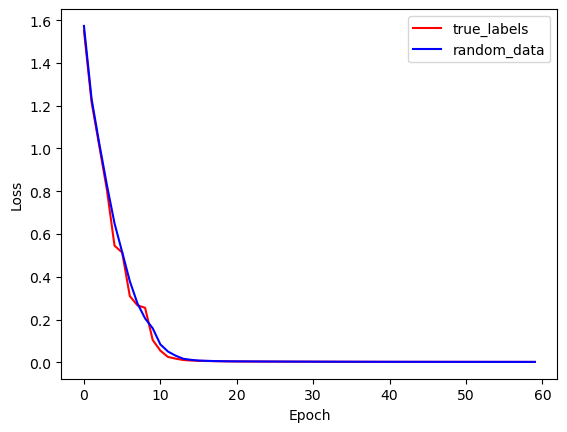

In [19]:
# Compute loss for true labels and plot
n_epoch = 60
loss_randomized_data = train_model(train_data_x_randomized, train_data_y, n_epoch)
# Plot the results
fig, ax = plt.subplots()
ax.plot(loss_true_labels,'r-',label='true_labels')
ax.plot(loss_randomized_data,'b-',label='random_data')
# ax.set_ylim(0,0.7); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [20]:
# TODO -- Permute the labels
# Replace this line:
train_data_y_permuted = np.copy(train_data_y)

# Shuffle the labels randomly
np.random.shuffle(train_data_y_permuted)

'Epoch 55, train loss 0.002'

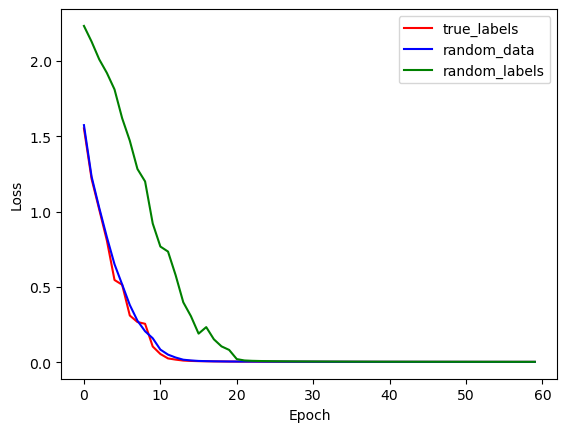

In [21]:
# Compute loss for true labels and plot
n_epoch = 60
loss_permuted_labels = train_model(train_data_x, train_data_y_permuted, n_epoch)
# Plot the results
fig, ax = plt.subplots()
ax.plot(loss_true_labels,'r-',label='true_labels')
ax.plot(loss_randomized_data,'b-',label='random_data')
ax.plot(loss_permuted_labels,'g-',label='random_labels')
# ax.set_ylim(0,0.7); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.legend()
plt.show()